Classifying spam vs no spam emails using BERT

In [2]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 25.8 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [5]:
import pandas as pd

df = pd.read_csv("spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [7]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [8]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [9]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [10]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [11]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [12]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [13]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
1530,ham,Should I have picked up a receipt or something...,0
2506,ham,Congrats kano..whr s the treat maga?,0
1086,ham,FR'NDSHIP is like a needle of a clock. Though ...,0
2053,spam,Call 09094100151 to use ur mins! Calls cast 10...,1
2398,ham,Neshanth..tel me who r u?,0


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [15]:
X_train.head(4)

812     So there's a ring that comes with the guys cos...
2575    Your next amazing xxx PICSFREE1 video will be ...
3954    Refused a loan? Secured or Unsecured? Can't ge...
2056                     Sir, I am waiting for your mail.
Name: Message, dtype: object

In [16]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [17]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up",
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351724, -0.5132727 , -0.88845736, ..., -0.7474883 ,
        -0.75314754,  0.91964495],
       [-0.87208354, -0.50543964, -0.94446665, ..., -0.85847497,
        -0.71745336,  0.88082975]], dtype=float32)>

In [18]:
# Get embeding vectors for few sample words. Compare them using cosine similarity

e = get_sentence_embeding([
    "banana",
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911088]], dtype=float32)

In [20]:
cosine_similarity([e[0]],[e[3]])

array([[0.84703803]], dtype=float32)

In [21]:
cosine_similarity([e[3]],[e[4]])

array([[0.9872035]], dtype=float32)

In [22]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [24]:
len(X_train)

1120

In [25]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [26]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 37s 397ms/step - loss: 0.5862 - accuracy: 0.7170 - precision: 0.7246 - recall: 0.7000
Epoch 2/10
35/35 [==============================] - 15s 418ms/step - loss: 0.4873 - accuracy: 0.8393 - precision: 0.8177 - recall: 0.8732
Epoch 3/10
35/35 [==============================] - 13s 363ms/step - loss: 0.4210 - accuracy: 0.8545 - precision: 0.8489 - recall: 0.8625
Epoch 4/10
35/35 [==============================] - 12s 330ms/step - loss: 0.3898 - accuracy: 0.8652 - precision: 0.8460 - recall: 0.8929
Epoch 5/10
35/35 [==============================] - 11s 328ms/step - loss: 0.3522 - accuracy: 0.8839 - precision: 0.8682 - recall: 0.9054
Epoch 6/10
35/35 [==============================] - 12s 338ms/step - loss: 0.3437 - accuracy: 0.8929 - precision: 0.8716 - recall: 0.9214
Epoch 7/10
35/35 [==============================] - 12s 336ms/step - loss: 0.3279 - accuracy: 0.8839 - precision: 0.8720 - recall: 0.9000
Epoch 8/10
35/35 [================

In [27]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 5s 321ms/step - loss: 0.2425 - accuracy: 0.9358 - precision: 0.9711 - recall: 0.8984


[0.24254900217056274,
 0.9358288645744324,
 0.9710982441902161,
 0.8983957171440125]

In [28]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 6s 425ms/step


In [29]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,

In [30]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[182,   5],
       [ 19, 168]])

Text(50.722222222222214, 0.5, 'Truth')

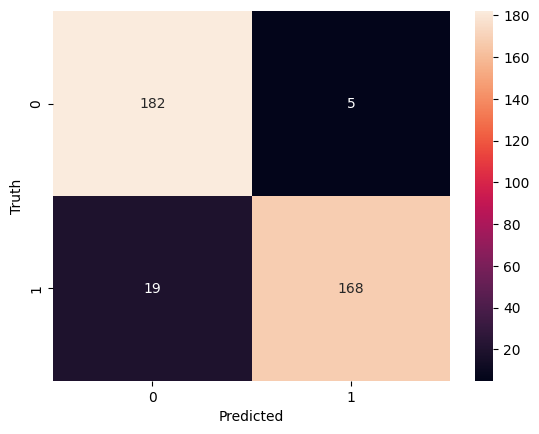

In [31]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [32]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       187
           1       0.97      0.90      0.93       187

    accuracy                           0.94       374
   macro avg       0.94      0.94      0.94       374
weighted avg       0.94      0.94      0.94       374



In [47]:
# Inference

reviews = [
    ['Enter a chance to win $5000, hurry up, offer valid until march 31, 2021'],
    ['You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99'],
    ['it to 80488. Your 500 free text messages are valid until 31 December 2005.'],
    ['Hey Sam, Are you coming for a cricket game tomorrow'],
    ["Why don't you wait 'til at least wednesday to see if you get your ."]
]

for sen in reviews:
  score = model.predict(sen)[0][0]

  if score > 0.5:
    print("Spam : ", sen[0])
  else:
    print("Not Spam : ", sen[0])


1/1 [==============================] - 0s 229ms/step
Spam :  Enter a chance to win $5000, hurry up, offer valid until march 31, 2021
1/1 [==============================] - 0s 241ms/step
Spam :  You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99
1/1 [==============================] - 0s 103ms/step
Spam :  it to 80488. Your 500 free text messages are valid until 31 December 2005.
1/1 [==============================] - 0s 184ms/step
Not Spam :  Hey Sam, Are you coming for a cricket game tomorrow
1/1 [==============================] - 0s 277ms/step
Not Spam :  Why don't you wait 'til at least wednesday to see if you get your .
